In [34]:
print('importing packages...')

importing packages...


In [35]:
import time
tot_tic = time.time()
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import sys
import pandas as pd
import cantera as ct
import numpy as np
import os
from scipy import interpolate
import plotly.graph_objects as go

In [36]:
########## System conditions ##########
lengths = [36,13,133,97] # inches
diameters = [20.5,15.5,10.5,8] # inches

SR_275 = 2.161
# SR_30 = 
SR_32 = 1.842
SR_34 = 1.737
SR_35 = 1.67
# SR_395 = 
SR_41 = 1.42
SR_43 = 1.357
SR_45 = 1.295

SR = SR_45 # stoichiometric ratio

exhaust_275 = 920 + 44.7
exhaust_32 = 912 + 52
exhaust_34 = 910 + 55
exhaust_41 = 898 + 66.6
exhaust_43 = 902 + 69.8
exhaust_45 = 900 + 73
exhaust_gas_q = exhaust_45 # total volumetric flow rate (L/min)
injection_loc = 55 # inches, see files\rainbow_ports.txt for list of port locations
injectant = 'CF4' # injected species, must be in quotations and match name in mechanism file
injectant_conc = 35e-6 # injected species concentration in furnace @ injection point (mol fraction)
output_folder = 'Output/CF4' # script will auto-generate the folder

########## Mechanism ##########
#mechanism = 'NCSU_PFASmech1.0.yaml' # mechanism file, irrelevant if 'yaml' = False
mechanism = 'NCSU_PFASmech1.0.yaml' # mechanism file, irrelevant if 'yaml' = False
yaml = True # if False, below chemkin format files will be converted to a Cantera friendly yaml file
kinetics = 'NCSU_PFASmech1.0_Kinetics.inp'
thermo = 'NCSU_PFASmech1.0_Thermo.dat'
output = 'new_mech_file.yaml' # must have .yaml extension

measured_temps_275 = [927,864,819,753,711,655,501,449,399,364] # °C
measured_temps_30 = [931, 906, 850, 803, 763, 712, 526, 477, 430, 391]
#measured_temps_32 = 
#measured_temps_34 =
#measured_temps_35 = 
measured_temps_395 = [1074, 1065, 996, 948, 889, 826, 598, 549, 497, 441]
#measured_temps_41 = 
#measured_temps_43 = 
measured_temps_45 = [1198, 1177, 1116, 1055, 997, 916, 649, 602, 553, 491]

########## Temperature fitting ##########
measured_temps = measured_temps_45 # °C
measured_temps_locs = [18,55,79,103,127,151,201,225,249,273] # inches
ff = 0.9 # "fudge factor" for flame temp because Cantera's solution is adiabatic
spline = True # fit using scipy.interpolate.UnivariateSpline (True) or numpy.polyfit (False)
k = 3 # spline degree
s = None # spline smoothing factor, see scipy documentation for guidance
pdeg = 4 # polynomial degree, only appliciable if 'spline' is set to False

########## Path diagram ##########
path_res_time = 0.001 # seconds, precision will be limited by grid resolution settings
path_element = 'F' # case sensitive
path_species = 'all' # 'all' or individual species name to only display fluxes connected to that species
path_threshold = 0.1 # kmol/m3/sec
path_details = False # or True

########## Grid resolution ##########
post_injection_res_time_step = 1e-3 # residence time grid size (seconds)
post_injection_duration = 1e-1 # seconds
elsewhere_res_time_step = 1e-2 # residence time grid size (seconds)

########## Additional settings ##########
run_with_dialog = False # Running with dialog may be best for public distributions
print_info_every = 100 # print simulation info every n time steps
atol = 1e-15 # absolute error tolerance for reactor equations solver
rtol = 1e-9 # relative error tolerance for reactor equations solver
it0 = True # generate output with pre-injection data trimmed off (True) or not trimmed (False)
concentrations_interactive_plot_cutoff = 1e-7 # mol fraction
rates_interactive_plot_cutoff = 1e-8 # mol/m3/s
save_rates_solution = False # Generating the net rates excel spreadsheet adds a lot of wall time
individual_plots = False # Generating individual species concentration plots adds a lot of wall time
major_species_cutoff = 1e-6 # mol fraction
minor_species_cutoff = 1e-15 # mol fraction

In [37]:

if os.path.exists(output_folder) == False: #check if output folder exists
    os.makedirs(output_folder) #create output folder if it doesn't exist

file = open(f'{output_folder}/log.txt', 'w') #create log file
file.close() #close log file

def myprint(txt): #print to console and log file
    print(txt, file=open(f'{output_folder}/log.txt', 'a'))
    print(txt)
    file.close()
    
def myinput(txt): #input to console and log file
    inp = input(txt)
    print(txt+inp, file=open(f'{output_folder}/log.txt', 'a'))
    file.close()
    return inp

In [38]:
# restart function only works for executable, not in python interpreter
def restart_main():
    executable = sys.executable
    executable_filename = os.path.split(executable)[1]
    os.execv(executable, sys.argv)

while os.system('dot -V') == 1:
    myprint('graphviz must be installed on your PATH to generate reaction pathway diagrams')
    time.sleep(1)
    myinput('press enter to launch graphviz installer')
    
    path_to_file = 'files/'
    exe = 'graphviz-install.exe'
    cur_dir = os.getcwd()
    os.chdir(path_to_file) # change folder
    os.system(f'{exe}')
    os.chdir(cur_dir) # go back
    
    myprint('graphviz installed -> restarting PFRTP run...')
    
    restart_main()

In [39]:
if yaml == False and os.path.exists(output) == True:
    myprint('output mechanism yaml file already exists -> no mechanism file format conversion necessary...')
    mechanism = output
elif yaml == False:
    myprint('converting chemkin mechanism files to yaml file...')
    args = f' python -m cantera.ck2yaml --input={kinetics} --thermo={thermo} --output={output} --permissive'
    os.system(args)
    mechanism = output
else:
    ...

In [40]:
myprint(' ')
gri_names = list(ct.Solution('files/gri3.0.yaml').species_names)
mech_names = list(ct.Solution(mechanism).species_names)
notin = []
for species in gri_names:
    if species in mech_names:
        ...
    else:
        notin.append(species)

if notin:
    myprint('WARNING! PFRTP uses the GRI-Mech 3.0 kinetic mechanism to estimate the composition of flame off-gas given the input stoichiometric ratio. '+
            'The subsequent evolution of that gas in the PFR system is based on the input kinetic mechanism.'+
            ' GRI-Mech 3.0 contains '+str(len(notin))+' species that were not identified in the input mechanism: '+" ".join(notin))
    myprint('You may wish to (a) check if any of the listed species are included in the input mechanism using a different name and rename them accordingly and/or (b) confirm that the listed species are not relevant in this case.')
    myprint('The GRI-Mech 3.0 file used by PFRTP can be found at files')
    myprint(' ')
    myprint(' ')
else:
    ...

 
WARNING! PFRTP uses the GRI-Mech 3.0 kinetic mechanism to estimate the composition of flame off-gas given the input stoichiometric ratio. The subsequent evolution of that gas in the PFR system is based on the input kinetic mechanism. GRI-Mech 3.0 contains 18 species that were not identified in the input mechanism: CH2 NH NH2 NH3 NNH NO NO2 N2O HNO CN HCN H2CN HCNN HCNO HOCN HNCO NCO CH2CHO
You may wish to (a) check if any of the listed species are included in the input mechanism using a different name and rename them accordingly and/or (b) confirm that the listed species are not relevant in this case.
The GRI-Mech 3.0 file used by PFRTP can be found at files
 
 


In [41]:
# Burn a flame and save the off-gas state as a yaml file.

ER = SR**-1
fname = 'files/flames/'+'flame_'+str(SR)+'.yaml'
if os.path.exists(fname) == False:
    myprint('flame solution does not exist for input SR -> solving flame...')
    To = 300
    Po = 101325
    gas = ct.Solution('files/gri3.0.yaml')
    gas.set_equivalence_ratio(ER, "CH4", {"O2": 1.0, "N2": 3.76})
    gas.TP = To, Po
    flame = ct.FreeFlame(gas)
    flame.solve(auto=True, loglevel=1)
    flame.gas.write_yaml(fname)
    myprint('flame solved -> creating polynomial fit for temperature profile...')
else:
    myprint('flame solution exists for input SR -> fitting temperature profile...')

flame solution does not exist for input SR -> solving flame...

************ Solving on 6 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.271e-05      3.754
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001095       2.11
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.02806      2.468
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.04494      2.301
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001125      3.901
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      5.63e-05      5.888
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.672e-05      6.076
Attempt Newton solution of s

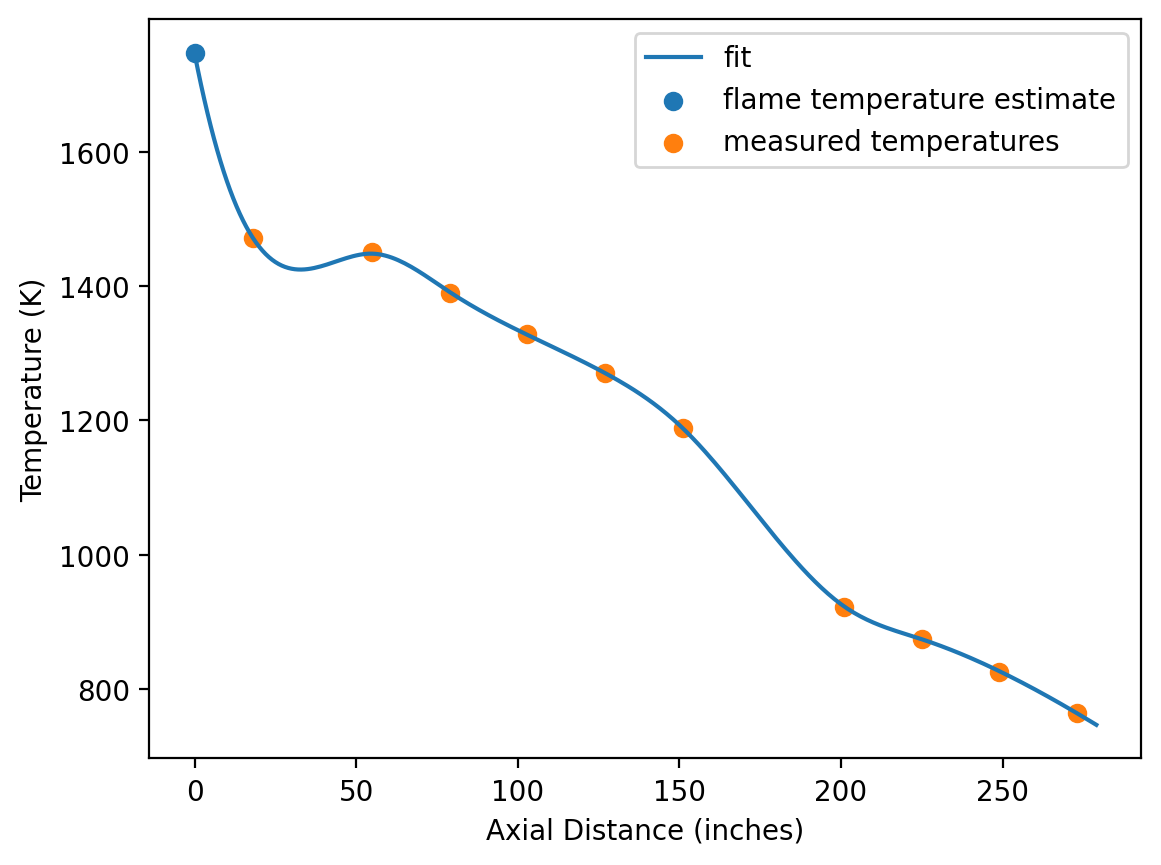

In [42]:
# Convert user input to model-friendly input

flame_temp_estimate = ct.Solution(fname).T*ff

if 0 in measured_temps_locs:
    measured_temps_new = [x+273.15 for x in measured_temps]
    measured_temps_locs_new = measured_temps_locs
else:
    measured_temps_new = [flame_temp_estimate]+[x+273.15 for x in measured_temps]
    measured_temps_locs_new = [0] + measured_temps_locs

# fit temps to axial length (a reasonable simplification)
xf = range(sum(lengths)+1)
if spline == True:
    spl = interpolate.UnivariateSpline(measured_temps_locs_new, measured_temps_new, k=k, s=s)
    T_fit = spl(xf)
else:
    z = np.polyfit(measured_temps_locs_new, measured_temps_new, pdeg)
    f = np.poly1d(z)
    T_fit = np.round(f(xf), 0) #### don't need round anymore?

# Plot fit
plt.plot(xf,T_fit,label='fit')
if 0 in measured_temps_locs:
    plt.scatter(measured_temps_locs,measured_temps_new,label='measured')
else:
    plt.scatter(0,flame_temp_estimate,label='flame temperature estimate')
    plt.scatter(measured_temps_locs,measured_temps_new[1:],label='measured temperatures')
plt.ylabel('Temperature (K)')
plt.xlabel('Axial Distance (inches)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_axial_distance.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show()

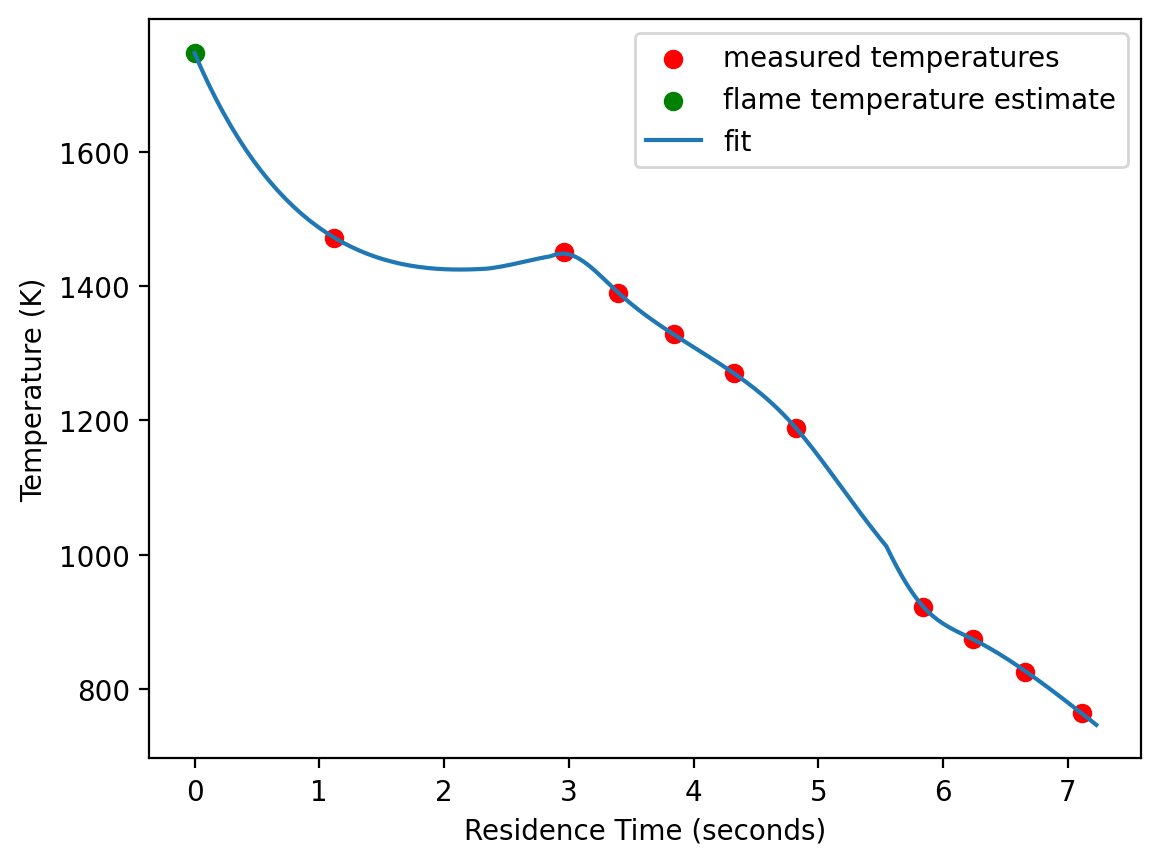

In [43]:
# Convert axial length fit to residence time fit based on slice volumes, temperatures, and flow rates

# start by making list of slice volumes, slices have 1-inch lengths
v = [0]
for l,d in zip(lengths,diameters):
    slice_lengths = np.zeros(l) + 1 # a list of "1"s the length of the nth section
    slice_vols = slice_lengths * np.pi * d**2 / 4 # a list of the corresponding volumes
    v.extend(list(slice_vols)) # extend the total list of volumes
    
Q = exhaust_gas_q * T_fit / 293.15 # list of T-corrected flows through each volume (L/min) based on ideal gas law
res_t = 60*np.array(v)/(61*Q) # list of slice res times (seconds), divided by 61 to convert L/min to in^3/min
t_cum = np.cumsum(res_t) # a list of slice cumulative res times (seconds)

# Plot fit
if 0 in measured_temps_locs:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new,c='red',label='measured')
else:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new[1:],c='red',label='measured temperatures')
    plt.scatter(t_cum[0],measured_temps_new[0],c="green",label='flame temperature estimate')
plt.plot(t_cum,T_fit,label='fit')
plt.ylabel('Temperature (K)')
plt.xlabel('Residence Time (seconds)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_res_time.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show();

In [44]:
myprint('plots of temperature profile fit saved to output folder')
if run_with_dialog == True:
    time.sleep(2)
    myinput('if satisfied with fit, press enter to run PFR simulation')
else:
    ...
myprint('PFR simulation running...')

plots of temperature profile fit saved to output folder
PFR simulation running...


In [45]:
# Interpolate res time fit to user-defined resolution
i_t = t_cum[np.round(injection_loc,0)] #res time at injection location

tgap1 = np.zeros(int(i_t/elsewhere_res_time_step)) + elsewhere_res_time_step # time steps before injection

tinj = np.zeros(int(post_injection_duration/post_injection_res_time_step)) + post_injection_res_time_step # time steps during injection

tgap2 = np.zeros(int((t_cum[-1]-i_t-post_injection_duration)/elsewhere_res_time_step)) + elsewhere_res_time_step # time steps after injection
 
tnew = np.concatenate(([0],tgap1,[i_t-sum(tgap1)],tinj,tgap2)) # list of res times (seconds) at user-defined resolution
f = interpolate.interp1d(t_cum, T_fit)  # interpolate temperature fit to res time fit, using t_cum as x and T_fit as y
Tnew = f(np.cumsum(tnew))

In [46]:
# define a function to map gri flame-gas species concentrations to mechanism species concentrations

def gri_to_mech(mech):
    gri_species = list(ct.Solution('files/gri3.0.yaml').species_names)
    mech_species = list(ct.Solution(mechanism).species_names)
    gri_c = list(ct.Solution(fname).X)
    mech_c = list(ct.Solution(mechanism).X)
    for species in gri_species:
        if species in mech_species:
            mech_c[mech_species.index(species)] = gri_c[gri_species.index(species)]
        else:
            ...
    return mech_c

In [47]:
# define the simulation loop for the res time vs. temp profile

def sim(T,t):
    intic = time.time()
    gas1,r1,sim1 = None,None,None
    pressure = ct.one_atm  # constant pressure [Pa]
    gas1 = ct.Solution(mechanism)
    concentrations = gri_to_mech(mechanism)
    rates = list(gas1.net_rates_of_progress)

    # determine index of injectant
    injectant_index = ct.Solution(mechanism).species_index(injectant)

    c=[]
    nrp=[]
    flag = False
    timestep = 0
    loop_t_cum = 0
    inj_i = len(tgap1)+2

    for T_i, t_i in zip(T,t):
        
        if timestep >= inj_i and flag == False:
            concentrations[injectant_index] = injectant_conc
            flag = True
        else:
            ...

        # wait to append concentrations until time of injection if it0 == True
        if it0 == False or flag == True:
            c.append(concentrations)
            nrp.append(rates)
        else:
            ...

        gas1.TPX = T_i, pressure, concentrations
        r1 = ct.IdealGasConstPressureReactor(gas1,energy="off")
        sim1 = ct.ReactorNet([r1])
        sim1.atol = atol
        sim1.rtol = rtol
        sim1.advance(t_i)
        concentrations = list(r1.thermo.X)
        rates = list(r1.thermo.net_rates_of_progress)

        timestep+=1
        loop_t_cum += t_i
        if (timestep % print_info_every == 0):
            intoc = time.time()
            myprint(
                f'timestep: {timestep}   total residence time (s): {str(round(loop_t_cum, 4))}   temperature (K): {str(round(T_i, 2))}   elapsed wall time(s): {str(round(intoc - intic, 2))}'
            )

    return c, nrp

In [48]:
# run the simulation
tic = time.time()
sim_data, nrp = sim(Tnew,tnew)
toc = time.time()
myprint(
    f'PFR simulation completed with wall time of: {str(round(toc - tic, 2))} seconds'
)

timestep: 100   total residence time (s): 0.99   temperature (K): 1488.1   elapsed wall time(s): 29.07
timestep: 200   total residence time (s): 1.99   temperature (K): 1425.3   elapsed wall time(s): 40.31
timestep: 300   total residence time (s): 2.9619   temperature (K): 1448.26   elapsed wall time(s): 50.27
timestep: 400   total residence time (s): 3.0889   temperature (K): 1440.0   elapsed wall time(s): 54.18
timestep: 500   total residence time (s): 4.0889   temperature (K): 1298.75   elapsed wall time(s): 60.72
timestep: 600   total residence time (s): 5.0889   temperature (K): 1124.82   elapsed wall time(s): 66.38
timestep: 700   total residence time (s): 6.0889   temperature (K): 887.87   elapsed wall time(s): 69.71
timestep: 800   total residence time (s): 7.0889   temperature (K): 766.97   elapsed wall time(s): 71.91
PFR simulation completed with wall time of: 72.18 seconds


In [49]:
# generate excel files
myprint(' ')
if run_with_dialog == True:
    time.sleep(2)
    myinput('press enter to generate output')
else:
    ...
myprint('generating and saving output to output folder...')

 
generating and saving output to output folder...


In [50]:
cantera_species = ct.Solution(mechanism).species_names
tplot = np.concatenate(([0],np.cumsum(tinj),np.cumsum(tgap2)+sum(tinj)))[:-1]
Tplot = Tnew[len(tnew)-len(sim_data):]

sim_data_new = list(np.array(sim_data).T)
sim_data_new.insert(0,Tplot)
sim_data_new.insert(0,tplot)
sol = np.array(sim_data_new).T
columns = ['Residence Time (seconds)','Temperature (K)'] + cantera_species
pd.DataFrame(sol,columns=columns).to_excel(output_folder+"\\solution_concentrations.xlsx")

In [51]:
eff_c = [] # effluent concentrations

for species in np.arange(len(cantera_species)):
    name = cantera_species[species]
    eff_c.append([name, np.array(sim_data)[:,species][-1]])

c = np.array(eff_c)
c_sorted = c[(c[:,1]).astype(float).argsort()[::-1]]
df = pd.DataFrame(c_sorted, columns=['Species','Effluent Concentration (mol fraction)'])
df.to_excel(output_folder+"\\solution_effluent_concentrations.xlsx")

In [52]:
cantera_reactions = list(ct.Solution(mechanism).reaction_equations())
if save_rates_solution == False:
    ...
else:
    nrp_new = list(np.array(nrp).T)
    nrp_new.insert(0,Tnew[len(tnew)-len(nrp):])
    nrp_new.insert(0,tplot)
    sol = np.array(nrp_new).T
    columns = ['Residence Time (seconds)','Temperature (K)'] + cantera_reactions
    pd.DataFrame(sol,columns=columns).to_excel(output_folder+"\\solution_reactions.xlsx")

In [53]:
data = np.array(sim_data).T
fig = go.Figure()
for i in np.arange(len(cantera_species)):
    if max(data[i])<concentrations_interactive_plot_cutoff:
        ...
    else:
        fig.add_trace(go.Scatter(x=tplot,y=data[i],name=cantera_species[i]))
fig.update_yaxes(title_text='Concentration (mol fraction)',type='log',exponentformat='power')
fig.update_xaxes(title_text='Residence Time (seconds)')
fig.update_layout(template='plotly_white')
fig.write_html(output_folder+"\\interactive_plot_concentrations.html")

In [54]:
data = np.array(nrp).T
fig = go.Figure()
for i in np.arange(len(cantera_reactions)):
    if max(data[i])<rates_interactive_plot_cutoff:
        ...
    else:
        fig.add_trace(go.Scatter(x=tplot,y=data[i],name=cantera_reactions[i]))
    
ylabel='Net Rate of Progress (kmol/m3/s)'
fig.update_yaxes(title_text=ylabel,type='log',exponentformat='power')
fig.update_xaxes(title_text='Residence Time (seconds)')
fig.update_layout(template='plotly_white')
fig.write_html(output_folder+"\\interactive_plot_net_rates.html")

In [55]:
# generate figures and excel files
# organize them based on maximum concentration across all slices

if individual_plots == True:
    if os.path.exists(output_folder+r"\\individual_major_species") == False:
        os.makedirs(output_folder+r"\\individual_major_species")
    if os.path.exists(output_folder+r"\\individual_minor_species") == False:
        os.makedirs(output_folder+r"\\individual_minor_species")
    neg_species = [] # negligible species
    eff_c = [] # effluent concentrations

    for species in np.arange(len(cantera_species)):
        name = cantera_species[species]
        eff_c.append([name, np.array(sim_data)[:,species][-1]])

        plt.plot(tplot,np.array(sim_data)[:,species])
        plt.xlabel('Residence time (seconds)')
        plt.ylabel('Concentration (mol fraction)')
        plt.title(name, fontsize=20,fontweight='bold')
        plt.yscale('log')
        if np.max(np.array(sim_data)[:,species]) > major_species_cutoff:
            plt.savefig(output_folder+'\\individual_major_species\\'+name+'.png',dpi=300,
                        bbox_inches='tight',facecolor='white');
        elif np.max(np.array(sim_data)[:,species]) > minor_species_cutoff:
            plt.savefig(output_folder+'\\individual_minor_species\\'+name+'.png',dpi=300,
                        bbox_inches='tight',facecolor='white');
        else:
            neg_species.append([name, np.max(np.array(sim_data)[:,species])])
        plt.close();

    df = pd.DataFrame(neg_species, columns=['Species', 'Maximum Concentration (mol fraction)'])
    df.to_excel(output_folder+"\\negligible_species.xlsx")
    
else:
    ...

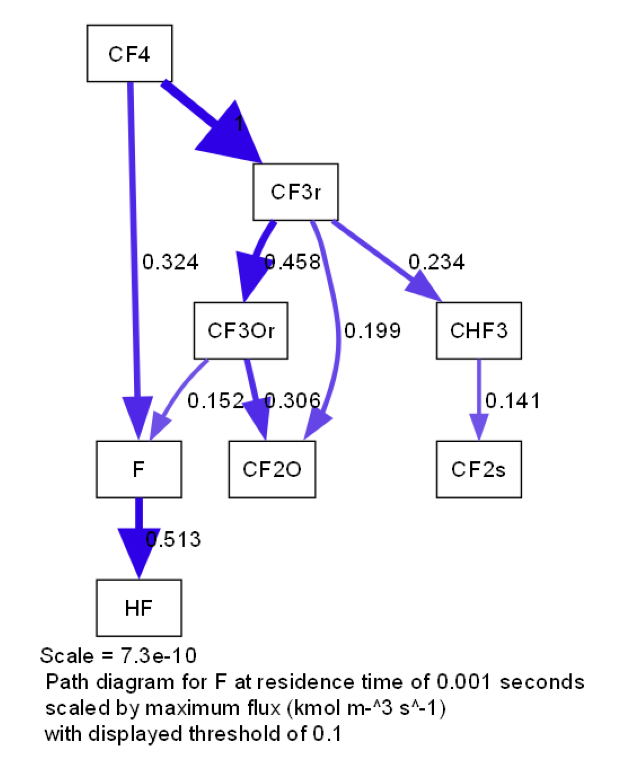

In [56]:
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)
retry = 'y'

while retry == 'y':
    plot_step = np.abs(tplot - path_res_time).argmin()
    P = ct.one_atm
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, path_element)
    diagram.threshold = path_threshold
    diagram.dot_options='node[shape="box"]'
    title = (
        (
            f'Path diagram for {path_element} at residence time of {str(path_res_time)}'
            + ' seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r'
        )
        + ' with displayed threshold of '
    ) + str(path_threshold)
    diagram.title = title
    diagram.show_details = path_details
    diagram.display_only(-1 if path_species == 'all' else gas.species_index(path_species))
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f'dot {dot_file} -Tpng -o {png_file} -Gdpi=100')
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    if run_with_dialog == True:
        retry = myinput('path diagram saved to output folder...generate new path diagram? (y/n): ')
    else:
        retry = 'n'
    if retry == 'y':
        path_res_time = float(myinput('type path diagram residence time (in seconds) and press enter: '))
        path_element = myinput('type path diagram element symbol and press enter: ')
        path_species = myinput('type path diagram species and press enter (all/individual species name): ')
        path_threshold = float(myinput('type path diagram threshold and press enter: '))
        path_details = input('show path details? (y/n) and press enter: ').lower().strip() == 'y'
    else:
        ...

In [57]:
tot_toc = time.time()
myprint(
    f'PFR run completed with total wall time of: {str(round(tot_toc - tot_tic, 2))} seconds'
)
time.sleep(3)

PFR run completed with total wall time of: 155.42 seconds


In [58]:
from ipywidgets import widgets, interact
from ipywidgets import SelectionSlider

In [59]:
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)

t_min = 0.0
t_max = post_injection_duration #max(tplot)
t_step = post_injection_res_time_step #elsewhere_res_time_step

thresh_min = 0.0
thresh_max = 1.0
thresh_step = 1e-2

def format_float(num):
    return np.format_float_positional(num, trim='-')

@interact(
    res_time=SelectionSlider(value=t_min+t_step,
                             options=[("%g"%i,i) for i in np.arange(t_min,t_max,t_step)]),
    threshold=SelectionSlider(value=thresh_min+thresh_step,
                              options=[("%g"%i,i) for i in np.arange(thresh_min,thresh_max,thresh_step)]),
    details=widgets.ToggleButton(),
    species=widgets.Dropdown(
        options=gas.element_names,
        value=path_element,
        description="Element",
        disabled=False,
    ),
)
def plot_reaction_path_diagrams(res_time, threshold, details, species):
    plot_step = np.abs(tplot - res_time).argmin()
    P = ct.one_atm
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, species)
    diagram.threshold = threshold
    diagram.dot_options='node[shape="box"]'
    diagram.show_details = details
    diagram.display_only(-1 if path_species == 'all' else gas.species_index(path_species))
    #diagram.display_only(gas.species_index('HOCL'))
    title = (
        (
            f'Path diagram for {species} at residence time of {str(res_time)}'
            + ' seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r'
        )
        + ' with displayed threshold of '
    ) + str(threshold)
    diagram.title = title
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f'dot {dot_file} -Tpng -o {png_file} -Gdpi=300')
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

interactive(children=(SelectionSlider(description='res_time', index=1, options=(('0', 0.0), ('0.001', 0.001), …